# Load packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate label file

In [2]:
from scripts.generate_labels import create_labeled_data

fai_path = "/home/jesslyn/Courses/IMLB/genome/hg19.fa.fai"
output_folder = "/home/jesslyn/Courses/IMLB/processed_data"
tf = 'CTCF'
create_labeled_data(tf, fai_path, output_folder)

CTCF labeled file already exists, skipping...


# Visualize data

In [3]:
df = pd.read_csv("processed_data/CTCF_full_labels.tsv", sep='\t')

In [4]:
df.head()

,Chromosome,Start,End,label
0,chr18,1724000,1724200,0
1,chr14,33460800,33461000,0
2,chr9,33937600,33937800,0
3,chr5,15131600,15131800,0
4,chr5,148290200,148290400,0


In [5]:
df.shape

(13637418, 4)

In [6]:
df['label'].value_counts()

label
0    13557347
1       80071
Name: count, dtype: int64

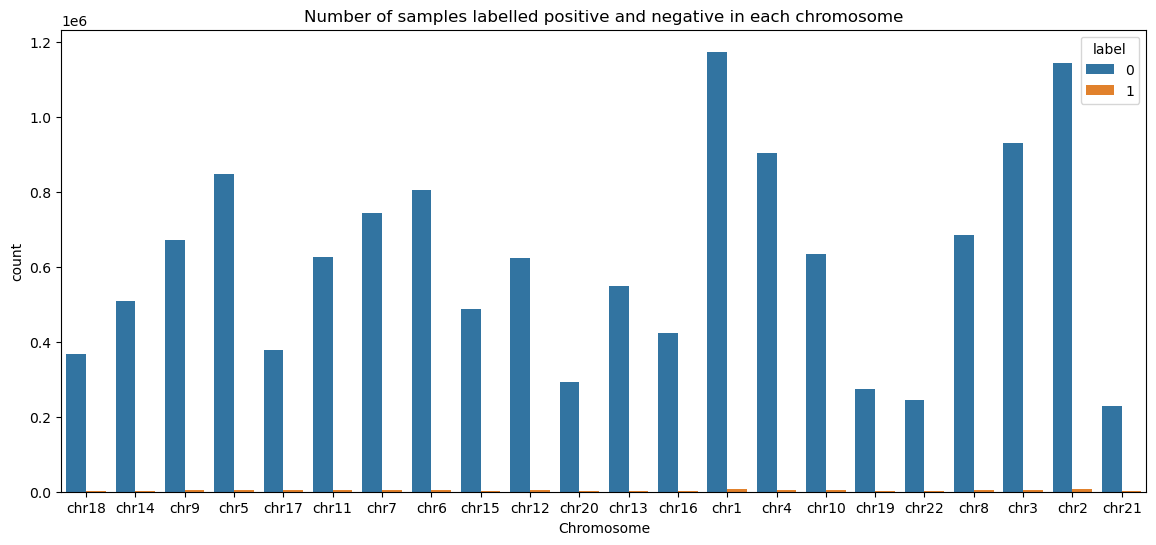

In [7]:
plt.figure(figsize=(14,6))
sns.countplot(df, x='Chromosome', hue='label')
plt.title("Number of samples labelled positive and negative in each chromosome")
plt.show()

# Generate train and test file

- Training/ Validation data: All chromosome except chr1 and chr21 (Downsampled negatives to 50x of positives)
- Test data: chr1 and chr21

In [8]:
test_chroms = ['chr1', 'chr21']
df_test = df[df['Chromosome'].isin(test_chroms)]
df_train = df[~df['Chromosome'].isin(test_chroms)]

In [9]:
# Keep all positive samples
df_pos = df_train[df_train['label'] == 1]

# Sample negative
df_neg = df_train[df_train['label'] == 0]
df_neg_sampled = (df_neg
                  .groupby('Chromosome', group_keys=False)
                  .apply(lambda x: x.sample(frac=df_pos.shape[0]*50/df_neg.shape[0]))
                  .sample(frac=1, random_state=42)
                  .reset_index(drop=True)
                  )

# Generate sampled training data
df_train_sampled = (pd.concat([df_pos, df_neg_sampled], ignore_index=False)
                    .sample(frac=1, random_state=42)
                    .reset_index(drop=True)
                    )

/tmp/ipykernel_4612/3065441268.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=df_pos.shape[0]*50/df_neg.shape[0]))


In [10]:
print(f"Number of train samples: {df_train_sampled.shape[0]}")
print(f"Number of test samples: {df_test.shape[0]}")

Number of train samples: 3636557
Number of test samples: 1413364


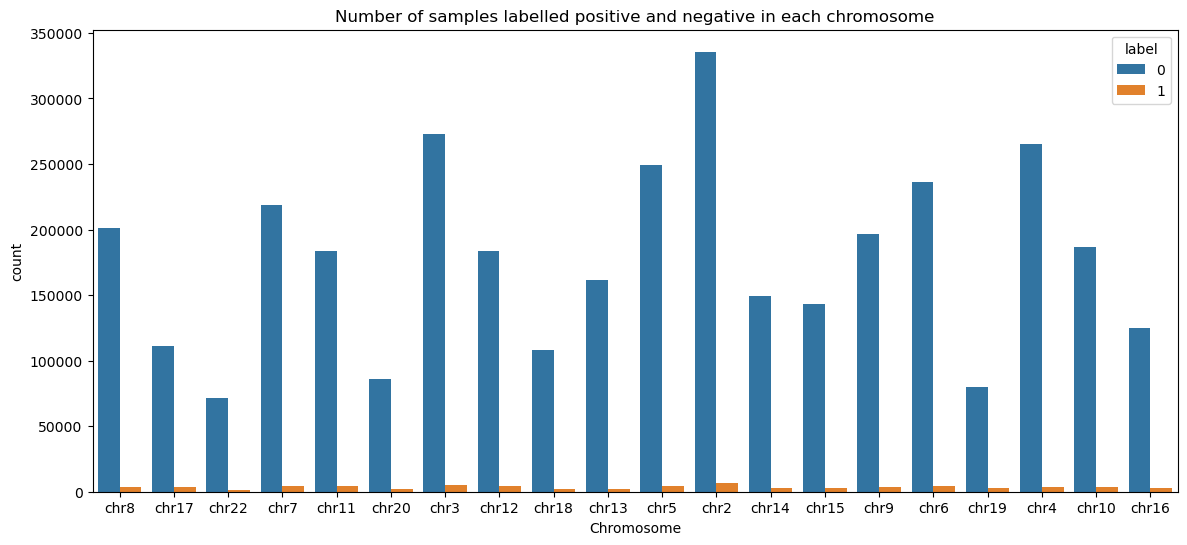

In [11]:
plt.figure(figsize=(14,6))
sns.countplot(df_train_sampled, x='Chromosome', hue='label')
plt.title("Number of samples labelled positive and negative in each chromosome")
plt.show()

In [12]:
from scripts.extract_seq import parallel_seq_chunked

df_test = parallel_seq_chunked(df_test)
df_test.to_parquet(f"{output_folder}/{tf}_test.parquet")

Processing chunks: 100%|██████████| 71/71 [08:35<00:00,  7.26s/it]


In [13]:
df_train_sampled = parallel_seq_chunked(df_train_sampled)
df_train_sampled.to_parquet(f"{output_folder}/{tf}_train.parquet")

Processing chunks: 100%|██████████| 182/182 [16:55<00:00,  5.58s/it]
